# Deep Convolutional Generative Adversarial Networks
This is a hands on experience building a Deep Convolutional Generative Adversarial Network (DCGAN). The following implementation is based on the [original paper](https://arxiv.org/pdf/1511.06434.pdf).

More details about this notebook as well as a quick introduction to GANs can be found in the accompanied article [here](https://medium.com/@nitwmanish/deep-convolutional-generative-adversarial-networks-dcgans-3176238b5a3d).

Download the CelebA dataset with name "img_align_celeba.zip” from this location https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg 
Create a directory with name "data" and keep img_align_celeba.zip in this direcory, location of directory with name "data" should be relative to this "dcgans-with-tensorflow.ipynb" script.
The download is 1.34GB large , so be sure to have enough disk space. There are 202,599 number of face images of various celebrities. All the face images, cropped and aligned.

This python code unzip "img_align_celeba.zip" file create a directory with name "celebA" under "data" directory. It also delete "img_align_celeba.zip" file.

In [1]:
import zipfile
import os
dirpath = './data'
filename = "img_align_celeba.zip"
data_dir = 'celebA'
zip_dir = ''
save_path = os.path.join(dirpath, filename)
if os.path.exists(save_path):
    with zipfile.ZipFile(save_path) as zf:
          zip_dir = zf.namelist()[0]
          zf.extractall(dirpath)
    os.remove(save_path)
    os.rename(os.path.join(dirpath, zip_dir), os.path.join(dirpath, data_dir))

I are also going to define few utility functions for batch generation. This functions will load our images and give me an array of images according to a batch size which I will be setting later. To get some better results, I will crop the images, so that only the faces will be shown. I will also normalize the images so that their values are in a range from -0,5 to +0,5. after that I am going to downscale the images to 28x28.

In [2]:
import os
from glob import glob
from PIL import Image
import numpy as np
# Image configuration
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
data_files = glob(os.path.join(dirpath, 'celebA/*.jpg'))
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3

def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    """
    image = Image.open(image_path)
    if image.size != (width, height):
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        # crop the images
        image = image.crop([j, i, j + face_width, i + face_height])
        # Downscale the images to 28x28
        image = image.resize([width, height], Image.BILINEAR)
    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single image
    """
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)
    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))
    return data_batch

def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255
    current_index = 0
    while current_index + batch_size <= shape[0]:
        data_batch = get_batch(
            data_files[current_index:current_index + batch_size],
            *shape[1:3])
        current_index += batch_size
        yield data_batch / IMAGE_MAX_VALUE - 0.5

In [3]:
import math
import numpy as np
from PIL import Image
from tqdm import tqdm
def images_square_grid(images, mode='RGB'):
    """
    Helper function to save images as a square grid (visualization)
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))
    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))
    return new_im

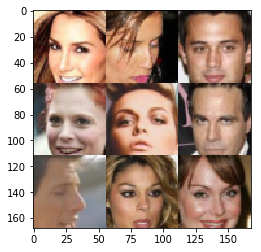

In [5]:
from matplotlib import pyplot
test_images = get_batch(glob(os.path.join(dirpath, 'celebA/*.jpg'))[:10], 56, 56) 
pyplot.imshow(images_square_grid(test_images))

# Defining network input

I need to create two networks, for that I will define inputs placeholder. 
Here, I am simply defining TensorFlow Placeholders for our real and fake inputs and for the learning rate.

In [6]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate

# The discriminator network

The discriminator is the “art critic”, who tries to distinguish between real and fake images. This is a convolutional neural network for image classification. The discriminator network consists of four convolutional layers. For every layer of the network, I am adding convolutional operations, then I am batch normalization operations to make the network faster and more accurate and finally, I am adding Leaky ReLu operations.

In [7]:
def discriminator(images, reuse=False):
    """
    The discriminator network
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        # ReLU activations Function
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        # Batch Normalization Operation
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
         # ReLU activations Function
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        # Batch Normalization Operation
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
         # ReLU activations Function
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
       
        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

# The generator network

The generator goes the other way: It is the artist who is trying to fool the discriminator. This network consists of four deconvolutional layers. I am doing the same as in the discriminator, just in the other direction. First, I take our input, called Z the feed it into the first deconvolutional layer. Each deconvolutional layer performs a deconvolution operations and then performs batch normalization operations and a leaky ReLu operations as well. Then, finally it return the tanh activation function.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    The generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 512))
        # Batch Normalization Operation
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        # ReLU activations Function
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Deconv 1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256, 5, 2, padding='VALID')
        # Batch Normalization Operation
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        # ReLU activations Function
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        
        # Deconv 2
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, 2, padding='SAME')
        # Batch Normalization Operation
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        # ReLU activations Function
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

# Loss Functions

Rather than just having a single loss function, here I need three loss function: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    loss for the discriminator and generator
    """
    
    label_smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #The loss of the Discriminator when using real images
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    #The loss of the Discriminator when using fake images
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    #The sum of the fake image and real image loss is the overall Discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    #The loss of the Generator
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    return d_loss, g_loss

# Optimization
I am using Adam Optimizer

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # use the Adam optimizer to minimize the loss for both nets
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

# Visualization

In the last step of our preparation, This is small helper function to display the generated images in the notebook for us, using the matplotlib library.

In [11]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    pyplot.imshow(images_square_grid(samples))
    pyplot.show()

# Training

Now, I define inputs, losses and optimizers, call a TensorFlow session and run it. Every 400 steps I am printing out the current progress by showing the generated image and loss.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 400 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3])

Epoch 1/2... Discriminator Loss: 0.9709... Generator Loss: 1.0215


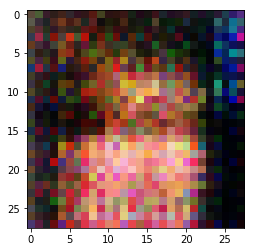

Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.8080


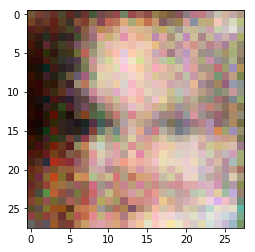

Epoch 1/2... Discriminator Loss: 1.3179... Generator Loss: 0.8640


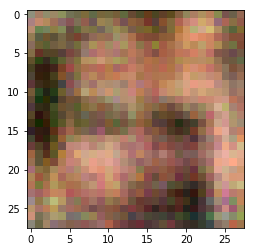

Epoch 1/2... Discriminator Loss: 1.2145... Generator Loss: 0.8499


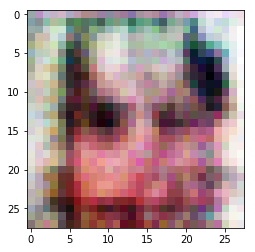

Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 0.8185


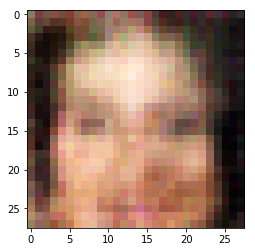

Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.8642


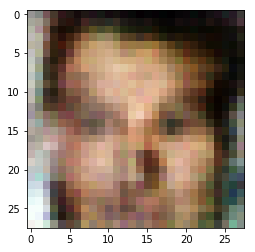

Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 0.8488


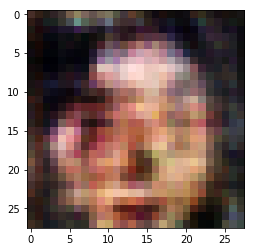

Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 0.7982


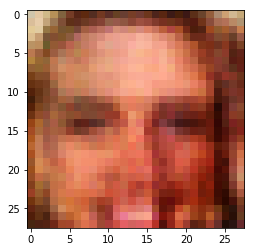

Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 0.8139


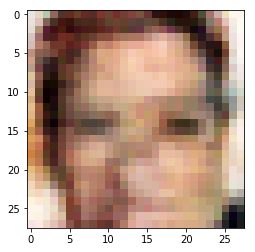

Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.8370


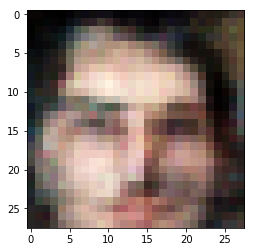

Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 0.8400


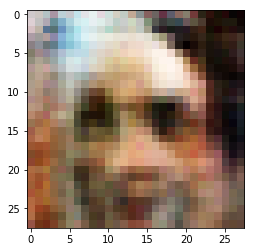

Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.7574


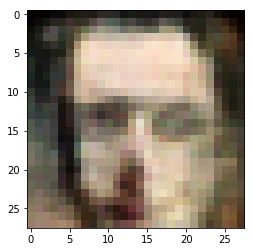

Epoch 1/2... Discriminator Loss: 1.1242... Generator Loss: 0.8351


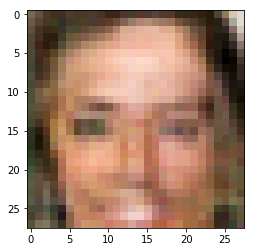

Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 0.7755


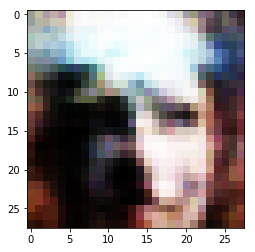

Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 0.8107


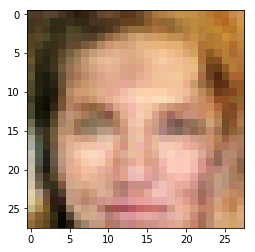

Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 0.8338


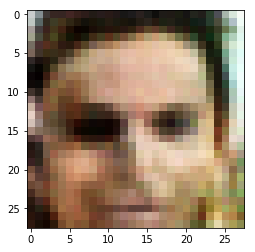

Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.8471


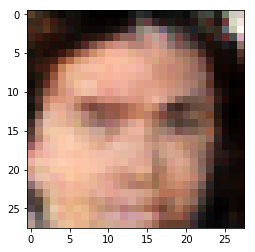

Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.8259


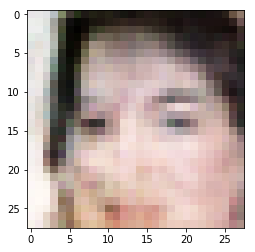

Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 0.7463


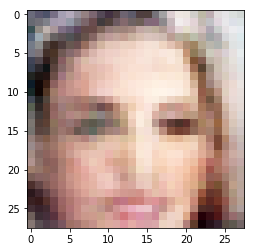

Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 0.8222


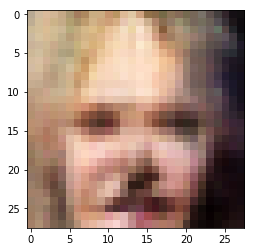

Epoch 1/2... Discriminator Loss: 1.0927... Generator Loss: 0.9348


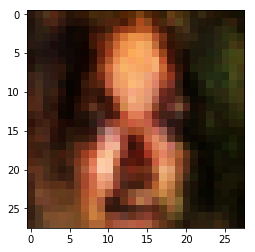

Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 0.8026


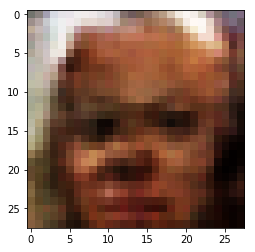

Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.8036


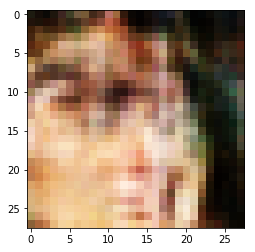

Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 0.9385


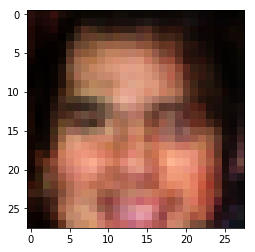

Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.8436


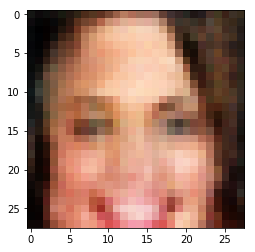

Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 0.8590


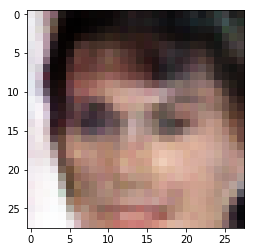

Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 0.9179


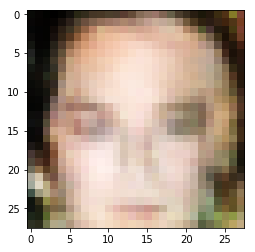

Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 0.7542


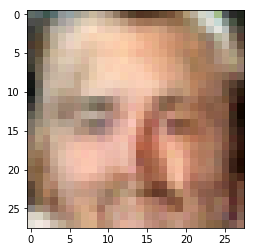

Epoch 1/2... Discriminator Loss: 1.6194... Generator Loss: 0.5070


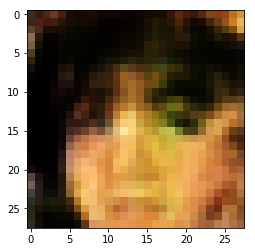

Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 0.8488


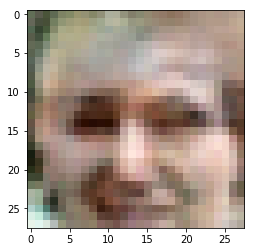

Epoch 1/2... Discriminator Loss: 1.1992... Generator Loss: 0.8712


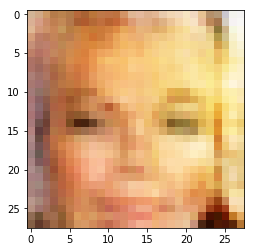

Epoch 2/2... Discriminator Loss: 1.2293... Generator Loss: 0.7946


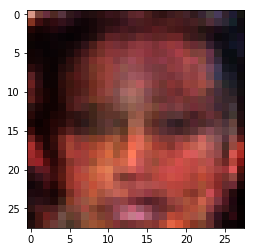

Epoch 2/2... Discriminator Loss: 1.2973... Generator Loss: 0.7854


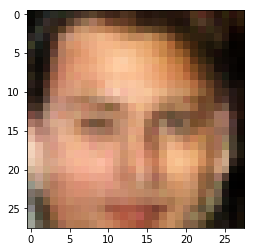

Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 0.9974


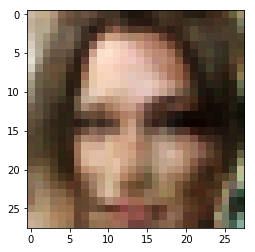

Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.9423


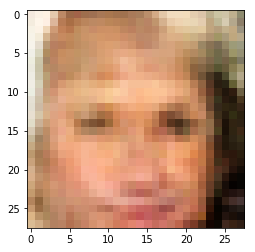

Epoch 2/2... Discriminator Loss: 1.5574... Generator Loss: 0.6580


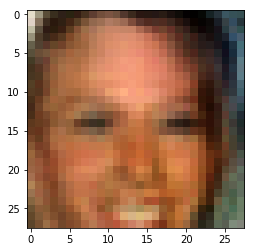

Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 0.8461


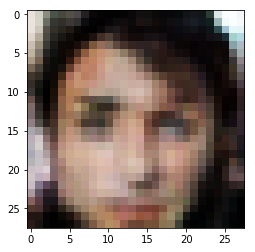

Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.7967


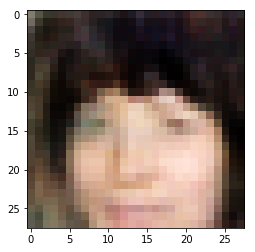

Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 0.9053


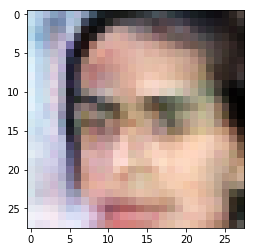

Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.6788


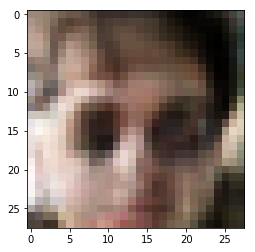

Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 1.0970


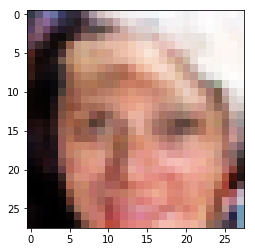

Epoch 2/2... Discriminator Loss: 1.0974... Generator Loss: 0.9328


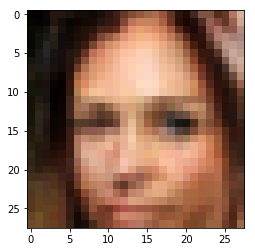

Epoch 2/2... Discriminator Loss: 1.2000... Generator Loss: 0.8575


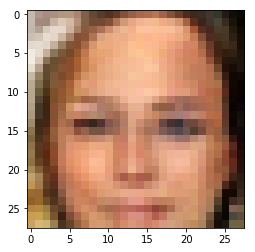

Epoch 2/2... Discriminator Loss: 0.9851... Generator Loss: 1.0425


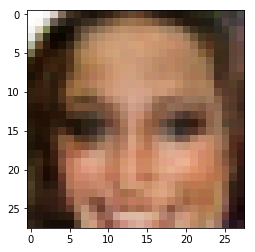

Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.8043


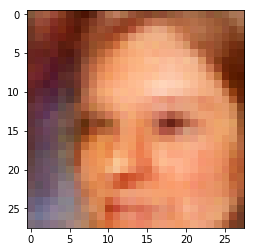

Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 0.8260


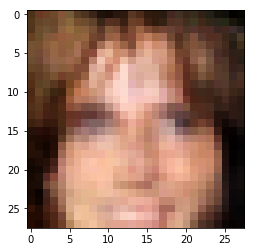

Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.6491


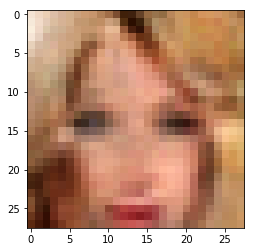

Epoch 2/2... Discriminator Loss: 1.1894... Generator Loss: 0.8974


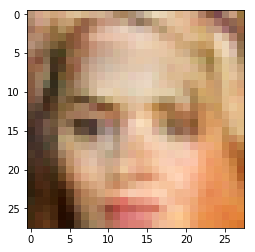

Epoch 2/2... Discriminator Loss: 1.1446... Generator Loss: 0.8511


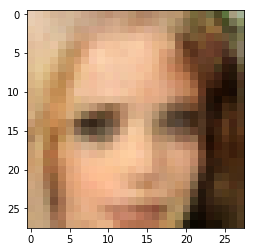

Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 0.8863


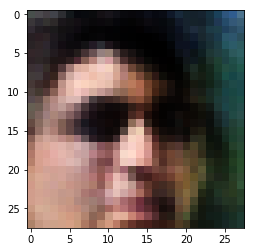

Epoch 2/2... Discriminator Loss: 0.9459... Generator Loss: 1.0308


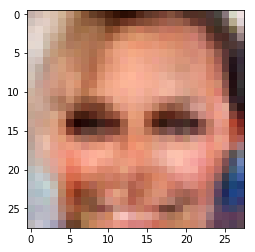

Epoch 2/2... Discriminator Loss: 1.0085... Generator Loss: 0.9192


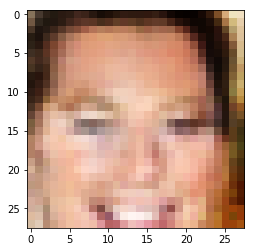

Epoch 2/2... Discriminator Loss: 1.2101... Generator Loss: 0.9508


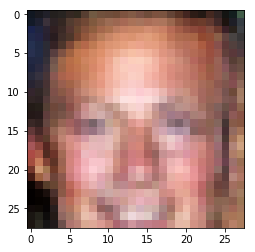

Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 0.8951


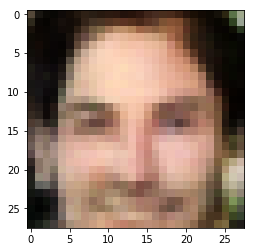

Epoch 2/2... Discriminator Loss: 1.4305... Generator Loss: 0.5536


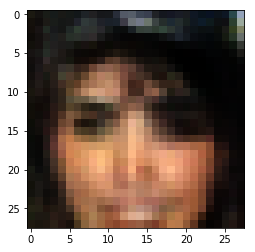

Epoch 2/2... Discriminator Loss: 1.2392... Generator Loss: 0.9151


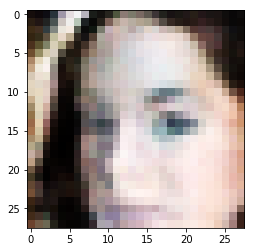

Epoch 2/2... Discriminator Loss: 1.0095... Generator Loss: 0.9453


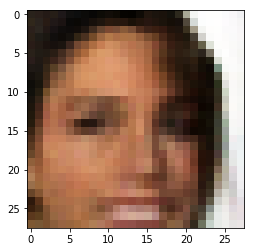

Epoch 2/2... Discriminator Loss: 1.1349... Generator Loss: 0.8501


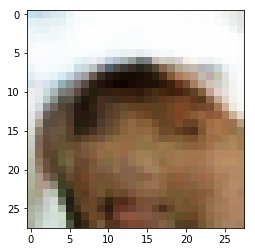

Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.7606


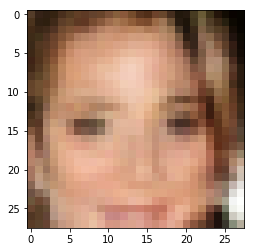

Epoch 2/2... Discriminator Loss: 1.1410... Generator Loss: 0.8267


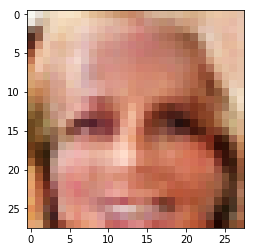

Epoch 2/2... Discriminator Loss: 1.0029... Generator Loss: 0.9514


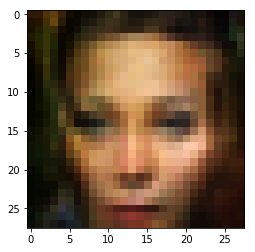

Epoch 2/2... Discriminator Loss: 1.1855... Generator Loss: 0.9256


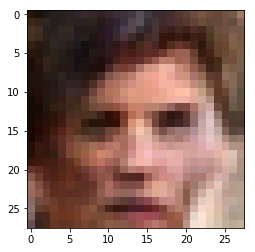

Epoch 2/2... Discriminator Loss: 0.9667... Generator Loss: 0.9328


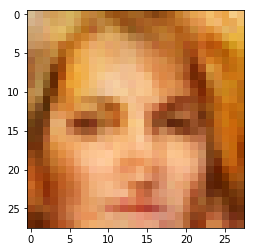

In [13]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 2

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)

#### The discriminator is good at finding the synthetic data points.
#### But, the generator improves over time based on feedback that the discriminator provides.